# Visualize score calibration of deployed model
This notebook loads back the deployed classification model to inspect its calibration, i.e. how well an output confidence score \[%\] reflects its accuracy.

Background: machine learning classifiers are typically overconfident, hence if outputted scores are expected to be used by the application in some way, their calibration needs to be understood first.

## Load model and calibration data

In [1]:
import mlflow

model = mlflow.pyfunc.load_model("models:/served-model/latest")

`torch_dtype` is deprecated! Use `dtype` instead!
`torch_dtype` is deprecated! Use `dtype` instead!
Device set to use cpu


In [2]:
import json

calibration_docs = []

for split in ["val", "test"]:
    with open(f"../data/swedish_sentiment_{split}.jsonl") as f:
        calibration_docs.extend(json.loads(l) for l in f.read().split("\n") if l)

len(calibration_docs)

100

## Compute scores

In [3]:
y_true = [1 if d["label"] == "positive" else 0 for d in calibration_docs]

predictions = [model.predict(d["text"]).squeeze().to_dict() for d in calibration_docs]
y_pred = [p["score"] if p["label"] == "positive" else 1 - p["score"] for p in predictions]

## Visualize calibration

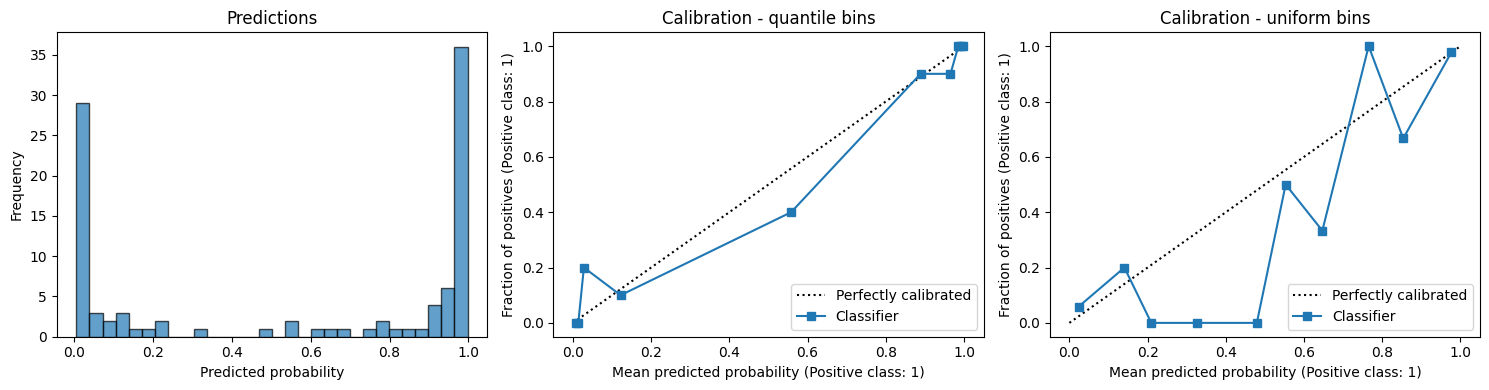

In [4]:
import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.hist(y_pred, bins=30, edgecolor="black", alpha=0.7)
ax1.set(title="Predictions", xlabel="Predicted probability", ylabel="Frequency")

CalibrationDisplay.from_predictions(y_true, y_pred, n_bins=10, strategy="quantile", ax=ax2)
ax2.set(title="Calibration - quantile bins")

CalibrationDisplay.from_predictions(y_true, y_pred, n_bins=10, strategy="uniform", ax=ax3)
ax3.set(title="Calibration - uniform bins")

plt.tight_layout()

## Interpretation
The prediction histogram indicates scores tend to saturate near 0 or 1, which is typical for overconfident models but could also be due to a lack of ambiguous samples in the calibration data.
The quantile-binned calibration curve reflects the same saturation towards 0 or 1 and two of its bins, located around predicted probability of 0.03 and 0.97, indicate overconfidence.
The uniformly binned curve shows erratic behaviour which reflects bad data coverage for most bins.

If output confidence scores are of interest, it is likely useful to gather more, realistic, calibration data with high-quality annotations before considering rescaling them using e.g. Platt scaling.